In [ ]:
#download pySpark

!java -version

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

!pip install pyspark

!pip install lifetimes

openjdk version "11.0.18" 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_362"
OpenJDK Runtime Environment (build 1.8.0_362-8u362-ga-0ubuntu1~20.04.1-b09)
OpenJDK 64-Bit Server VM (build 25.362-b09, mixed mode)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=b3a700982298a7d1ae359c9882b7f98ca83f60f5ebc3dd879bdad2422d3ad382
  Stored in directory: /root/.cache/pip/wheels/6c/e3

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import unix_timestamp, col, to_date, struct, abs,when, round
from pyspark.sql.functions import to_utc_timestamp, lit, datediff

import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("App_Name") \
    .config("spark.driver.memory", "64g") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/NDSU_capstone/3.proceeded_data/all_transaction.zip' -d '/content/drive/MyDrive/NDSU_capstone/all_transaction_from2016'

In [ ]:
path = '/content/drive/MyDrive/NDSU_capstone/3.proceeded_data/all_transaction_from2016'
parDF=spark.read.parquet(path)

NameError: ignored

In [ ]:
parDF.count()

130910557

In [ ]:
from pyspark.sql.functions import count
def my_count(df_in):
  df_in.agg( *[ count(c).alias(c) for c in df_in.columns ] ).show()

In [ ]:
my_count(parDF)

+---------+---------+------------------+------------+-------------+--------------------+---------+---------+-----------------+---------+---------+-----------+--------------+---------+-----------+---------+------------+-----------------+-------------+
|  ACCTKEY| RTXN_AMT|BAL_AFTER_RTXN_AMT|RTXN_TYPE_CD|ACT_DATE_TIME|SIGNED_BASED_TXN_FLG|   BRANCH|      TXT|RECURRING_TRAN_YN| SICSUBCD|  abs_AMT|ACTIVE_DATE|account_status|closed_dt|eom_prod_dt|  balance|orig_bal_amt|minor_description|Household_key|
+---------+---------+------------------+------------+-------------+--------------------+---------+---------+-----------------+---------+---------+-----------+--------------+---------+-----------+---------+------------+-----------------+-------------+
|130910557|130910557|         130910557|   130910557|    130910557|           119458933|130910557|130907153|        130521142|109951033|130910557|  130874562|     130910557| 12265853|  130910557|130910557|   130910557|        130910557|    1309105

In [ ]:
parDF.printSchema()

root
 |-- ACCTKEY: string (nullable = true)
 |-- RTXN_AMT: string (nullable = true)
 |-- BAL_AFTER_RTXN_AMT: string (nullable = true)
 |-- RTXN_TYPE_CD: string (nullable = true)
 |-- ACT_DATE_TIME: string (nullable = true)
 |-- SIGNED_BASED_TXN_FLG: string (nullable = true)
 |-- BRANCH: string (nullable = true)
 |-- TXT: string (nullable = true)
 |-- RECURRING_TRAN_YN: string (nullable = true)
 |-- SICSUBCD: string (nullable = true)
 |-- abs_AMT: double (nullable = true)
 |-- ACTIVE_DATE: string (nullable = true)
 |-- account_status: string (nullable = true)
 |-- closed_dt: string (nullable = true)
 |-- eom_prod_dt: string (nullable = true)
 |-- balance: string (nullable = true)
 |-- orig_bal_amt: string (nullable = true)
 |-- minor_description: string (nullable = true)
 |-- Household_key: string (nullable = true)



In [ ]:
df1 = parDF.select("ACCTKEY","RTXN_AMT","BAL_AFTER_RTXN_AMT","RTXN_TYPE_CD","ACT_DATE_TIME")

In [ ]:
df = df1.withColumn('abs_AMT',abs(df1.RTXN_AMT))

In [ ]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df1 = df.withColumn("date", to_date(col("ACT_DATE_TIME"), "MM/dd/yyyy"))

In [ ]:
#calculate the time diference
from pyspark.sql.functions import mean, min, max, sum, datediff, to_date
date_max = df1.select(max('ACT_DATE_TIME')).toPandas()
current = to_utc_timestamp( unix_timestamp(lit(str(date_max.iloc[0][0])), \
'yy-MM-dd').cast('timestamp'), 'UTC' )
# Calculatre Duration
df2 = df1.withColumn('Duration', datediff(lit(current), 'ACT_DATE_TIME'))

In [ ]:
df2.show(20)

+--------------------+--------+------------------+------------+-------------------+-------+----+--------+
|             ACCTKEY|RTXN_AMT|BAL_AFTER_RTXN_AMT|RTXN_TYPE_CD|      ACT_DATE_TIME|abs_AMT|date|Duration|
+--------------------+--------+------------------+------------+-------------------+-------+----+--------+
|006c746699f856a48...|  -25.27|            677.24|        PWTH|2020-12-19 08:48:25|  25.27|null|     636|
|006c746699f856a48...|   -6.89|           1182.57|        PWTH|2020-12-29 03:58:07|   6.89|null|     626|
|006c746699f856a48...|  -15.99|           1557.42|        PWTH|2020-10-01 01:08:17|  15.99|null|     715|
|006c746699f856a48...|  -61.53|           5485.93|        PWTH|2020-10-18 13:41:42|  61.53|null|     698|
|006c746699f856a48...|   -15.0|           1161.79|        PWTH|2020-10-08 20:12:28|   15.0|null|     708|
|006c746699f856a48...|  -17.63|           2706.42|        PWTH|2020-11-01 23:22:58|  17.63|null|     684|
|006c746699f856a48...|  -66.19|           3787

In [ ]:
# build the Recency, Frequency and Monetary
recency = df2.groupBy('ACCTKEY').agg(min('Duration').alias('Recency'))
frequency = df2.groupBy('ACCTKEY').agg(count("*").alias("Frequency"))
monetary = df2.groupBy('ACCTKEY').agg(sum('abs_AMT').alias('Monetary'))

In [ ]:
recency.count()

175874

In [ ]:
frequency.count()

175874

In [ ]:
monetary.count()

175874

In [ ]:
rfm = recency.join(frequency,'ACCTKEY', how = 'inner').join(monetary,'ACCTKEY',how = 'inner')


In [ ]:
rfm.show(10)

+--------------------+-------+---------+------------------+
|             ACCTKEY|Recency|Frequency|          Monetary|
+--------------------+-------+---------+------------------+
|00c29bdeb383e3cbe...|     17|      891|36240.000000000015|
|00fdb9ca769eb43a2...|     47|      196| 6933.230000000001|
|00fe66ef2848f8dd5...|     28|       11|           1138.78|
|014547448b9789667...|     17|     2006|238012.93000000017|
|017d1e3d6835512a7...|     22|      187|151454.88999999998|
|01b6225806955e321...|     18|     1548| 97929.06999999998|
|021a7cef65a88edd5...|     17|     2080|214612.16000000056|
|02467462bfbe913b3...|    127|      994| 54816.67000000002|
|027d6e3b1184182d7...|     18|      343|30469.479999999996|
|036dc457434675344...|    295|       44|           6232.19|
+--------------------+-------+---------+------------------+
only showing top 10 rows



In [ ]:
rfm.dtypes

[('ACCTKEY', 'string'),
 ('Recency', 'int'),
 ('Frequency', 'bigint'),
 ('Monetary', 'double')]

In [ ]:
rfm_model = rfm.withColumn("Monetary", func.round(rfm["monetary"], 2))

In [ ]:
rfm_model.show(10)

+--------------------+-------+---------+---------+
|             ACCTKEY|Recency|Frequency| Monetary|
+--------------------+-------+---------+---------+
|00c29bdeb383e3cbe...|     17|      891|  36240.0|
|00fdb9ca769eb43a2...|     47|      196|  6933.23|
|00fe66ef2848f8dd5...|     28|       11|  1138.78|
|014547448b9789667...|     17|     2006|238012.93|
|017d1e3d6835512a7...|     22|      187|151454.89|
|01b6225806955e321...|     18|     1548| 97929.07|
|021a7cef65a88edd5...|     17|     2080|214612.16|
|02467462bfbe913b3...|    127|      994| 54816.67|
|027d6e3b1184182d7...|     18|      343| 30469.48|
|036dc457434675344...|    295|       44|  6232.19|
+--------------------+-------+---------+---------+
only showing top 10 rows



In [ ]:
###RFM Segmentation

In [ ]:
rfm_model.describe().show()

+-------+--------------------+------------------+-----------------+------------------+
|summary|             ACCTKEY|           Recency|        Frequency|          Monetary|
+-------+--------------------+------------------+-----------------+------------------+
|  count|              175874|            175874|           175874|            175874|
|   mean|                null|113.38656651921262|744.3428647781935|102743.06754710771|
| stddev|                null|206.94822929191187| 926.341513213273|138997.01435319585|
|    min|00002008dddb4c8dc...|                 0|                1|              0.01|
|    max|fffeea055a3792b35...|              1050|            11558|        6693741.74|
+-------+--------------------+------------------+-----------------+------------------+



In [ ]:
def describe_pd(df_in, columns, deciles=False):
    '''
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

    :author: Ming Chen and Wenqiang Feng
    :email:  von198@gmail.com
    '''

    if deciles:
        percentiles = np.array(range(0, 110, 10))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [ ]:
cols = ['Recency','Frequency','Monetary']
describe_pd(rfm_model,cols)

,summary,Recency,Frequency,Monetary
0,count,175874,175874,175874
1,mean,113.38656651921262,744.3428647781935,102743.06754710771
2,stddev,206.94822929191187,926.341513213273,138997.01435319585
3,min,0,1,0.01
4,max,1050,11558,6693741.74
5,25%,17.0,71.0,9995.705
6,50%,19.0,337.0,55076.89
7,75%,48.0,1157.0,150295.855


In [ ]:
def RScore(x):
  if x <= 17:
    return 1
  elif x<= 18:
    return 2
  elif x<= 34:
    return 3
  else:
    return 4

def FScore(x):
  if x <= 49:
    return 4
  elif x <= 243:
    return 3
  elif x <= 779:
    return 2
  else:
    return 1

def MScore(x):
  if x <= 8207.4:
    return 4
  elif x <= 40294.89:
    return 3
  elif x <= 100044.19:
    return 2
  else:
    return 1

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType

R_udf = udf(lambda x: RScore(x), StringType())
F_udf = udf(lambda x: FScore(x), StringType())
M_udf = udf(lambda x: MScore(x), StringType())


In [ ]:
rfm_seg = rfm_model.withColumn("r_seg", R_udf("Recency"))
rfm_seg = rfm_seg.withColumn("f_seg", F_udf("Frequency"))
rfm_seg = rfm_seg.withColumn("m_seg", M_udf("Monetary"))
rfm_seg.show(5)

+--------------------+-------+---------+---------+-----+-----+-----+
|             ACCTKEY|Recency|Frequency| Monetary|r_seg|f_seg|m_seg|
+--------------------+-------+---------+---------+-----+-----+-----+
|00c29bdeb383e3cbe...|     17|      891|  36240.0|    1|    1|    3|
|00fdb9ca769eb43a2...|     47|      196|  6933.23|    4|    3|    4|
|00fe66ef2848f8dd5...|     28|       11|  1138.78|    3|    4|    4|
|014547448b9789667...|     17|     2006|238012.93|    1|    1|    1|
|017d1e3d6835512a7...|     22|      187|151454.89|    3|    3|    1|
+--------------------+-------+---------+---------+-----+-----+-----+
only showing top 5 rows



In [ ]:
rfm_seg = rfm_seg.withColumn('RFMScore',F.concat(F.col('r_seg'),F.col('f_seg'), F.col('m_seg')))
rfm_seg.sort(F.col('RFMScore')).show(5)

+--------------------+-------+---------+---------+-----+-----+-----+--------+
|             ACCTKEY|Recency|Frequency| Monetary|r_seg|f_seg|m_seg|RFMScore|
+--------------------+-------+---------+---------+-----+-----+-----+--------+
|03c664fd732de5de1...|     17|     2328|289773.66|    1|    1|    1|     111|
|01d5dc224f9c0f2e5...|     17|     2627|284945.36|    1|    1|    1|     111|
|011c817919a6b16f2...|     17|     4139|558124.35|    1|    1|    1|     111|
|159e10c9afc99198e...|     17|     2255|182925.35|    1|    1|    1|     111|
|09dabf729c6d038ad...|     17|     1278|136383.13|    1|    1|    1|     111|
+--------------------+-------+---------+---------+-----+-----+-----+--------+
only showing top 5 rows



In [ ]:
rfm_seg.coalesce(1).write.csv('/content/drive/MyDrive/NDSU_capstone/3.proceeded_data/RFM_score')

In [ ]:
###RFM ANALYSIS

In [ ]:
!pip install feature_engine

     |████████████████████████████████| 319 kB 2.5 MB/s eta 0:00:01


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.offline as pyoff
import plotly.graph_objs as go
import datetime as dt
import feature_engine
from feature_engine.outliers import Winsorizer
import warnings
warnings.filterwarnings("ignore")

In [ ]:
path1 = '/content/drive/MyDrive/NDSU_capstone/3.proceeded_data/RFM_SCORE_TRANG.csv'
segmented_rfm = pd.read_csv(path1)

In [ ]:
segmented_rfm.head(10)

,ACCTKEY,Recency,Frequency,Monetary,R_quartile,F_quatile,M_quartile,RFM_segment\t,RFMScore
0,00c29bdeb383e3cbe1639ccf2e121419,17,891,36240.00,1,1,3,113,5
1,00fdb9ca769eb43a2912f178b7f3c017,47,196,6933.23,4,3,4,434,11
2,00fe66ef2848f8dd5bb151548c65a6de,28,11,1138.78,3,4,4,344,11
3,014547448b9789667df757089ea2ab6c,17,2006,238012.93,1,1,1,111,3
4,017d1e3d6835512a7a15f25d9d18c15f,22,187,151454.89,3,3,1,331,7
5,01b6225806955e3212e83b81a8eca9a8,18,1548,97929.07,2,1,2,212,5
6,021a7cef65a88edd5a586a5fdb2e321f,17,2080,214612.16,1,1,1,111,3
7,02467462bfbe913b34fc627b6dee7248,127,994,54816.67,4,1,2,412,7
8,027d6e3b1184182d7d7c56838b5dc63a,18,343,30469.48,2,2,3,223,7
9,036dc4574346753449969e74c51740ba,295,44,6232.19,4,4,4,444,12


In [ ]:
segmented_rfm.rename(columns={'RFM_segment\t': 'RFM_segment'}, inplace=True)

In [ ]:
segmented_rfm.head()

,ACCTKEY,Recency,Frequency,Monetary,R_quartile,F_quatile,M_quartile,RFM_segment,RFMScore
0,00c29bdeb383e3cbe1639ccf2e121419,17,891,36240.00,1,1,3,113,5
1,00fdb9ca769eb43a2912f178b7f3c017,47,196,6933.23,4,3,4,434,11
2,00fe66ef2848f8dd5bb151548c65a6de,28,11,1138.78,3,4,4,344,11
3,014547448b9789667df757089ea2ab6c,17,2006,238012.93,1,1,1,111,3
4,017d1e3d6835512a7a15f25d9d18c15f,22,187,151454.89,3,3,1,331,7


In [ ]:
#### Supervised learning - Kmean

In [ ]:
RFM_Table = segmented_rfm[['Recency','Frequency','Monetary']].copy()
RFM_Table.head()

,Recency,Frequency,Monetary
0,17,891,36240.00
1,47,196,6933.23
2,28,11,1138.78
3,17,2006,238012.93
4,22,187,151454.89


In [ ]:
RFM_Table['index_col'] = RFM_Table.index
RFM_Table.head()

,Recency,Frequency,Monetary,index_col
0,17,891,36240.00,0
1,47,196,6933.23,1
2,28,11,1138.78,2
3,17,2006,238012.93,3
4,22,187,151454.89,4


In [ ]:
segmented_rfm.dtypes

ACCTKEY         object
Recency          int64
Frequency        int64
Monetary       float64
R_quartile       int64
F_quatile        int64
M_quartile       int64
RFM_segment      int64
RFMScore         int64
dtype: object

In [ ]:
df = segmented_rfm.astype({'RFM_segment': "string",'Monetary': "int64"})
print(df.dtypes)

ACCTKEY        object
Recency         int64
Frequency       int64
Monetary        int64
R_quartile      int64
F_quatile       int64
M_quartile      int64
RFM_segment    string
RFMScore        int64
dtype: object


In [ ]:
df.describe()

,Recency,Frequency,Monetary,R_quartile,F_quatile,M_quartile,RFMScore
count,175874.000000,175874.000000,1.758740e+05,175874.000000,175874.000000,175874.000000,175874.000000
mean,113.386567,744.342865,1.027426e+05,2.499795,2.313696,2.305201,7.118693
std,206.948229,926.341513,1.389970e+05,1.218314,1.151882,1.183558,3.020331
min,0.000000,1.000000,0.000000e+00,1.000000,1.000000,1.000000,3.000000
25%,17.000000,71.000000,9.995250e+03,1.000000,1.000000,1.000000,4.000000
50%,19.000000,337.000000,5.507650e+04,3.000000,2.000000,2.000000,7.000000
75%,48.000000,1157.000000,1.502950e+05,4.000000,3.000000,3.000000,10.000000
max,1050.000000,11558.000000,6.693741e+06,4.000000,4.000000,4.000000,12.000000


In [ ]:
df.head(10)

,ACCTKEY,Recency,Frequency,Monetary,R_quartile,F_quatile,M_quartile,RFM_segment,RFMScore
0,00c29bdeb383e3cbe1639ccf2e121419,17,891,36240,1,1,3,113,5
1,00fdb9ca769eb43a2912f178b7f3c017,47,196,6933,4,3,4,434,11
2,00fe66ef2848f8dd5bb151548c65a6de,28,11,1138,3,4,4,344,11
3,014547448b9789667df757089ea2ab6c,17,2006,238012,1,1,1,111,3
4,017d1e3d6835512a7a15f25d9d18c15f,22,187,151454,3,3,1,331,7
5,01b6225806955e3212e83b81a8eca9a8,18,1548,97929,2,1,2,212,5
6,021a7cef65a88edd5a586a5fdb2e321f,17,2080,214612,1,1,1,111,3
7,02467462bfbe913b34fc627b6dee7248,127,994,54816,4,1,2,412,7
8,027d6e3b1184182d7d7c56838b5dc63a,18,343,30469,2,2,3,223,7
9,036dc4574346753449969e74c51740ba,295,44,6232,4,4,4,444,12


In [ ]:
print("Core Customers: ",len(df[df['RFM_segment']=='111']))
print("Loyal Customers: ",len(df[df['R_quartile']==1]))
print("Big Spenders: ",len(df[df['M_quartile']==1]))
print("At risk Customers: ",len(df[df['RFM_segment']=='134']))
print("Lost Customers: ",len(df[df['RFM_segment']=='344']))
print("Lost Cheap Customers: ",len(df[df['RFM_segment']=='444']))

Core Customers:  26936
Loyal Customers:  57356
Big Spenders:  64163
Almost Lost:  1762
Lost Customers:  5091
Lost Cheap Customers:  19290


In [ ]:
###Here we are normalizing the rank of the customers within a company to analyze the ranking.

In [ ]:
df['R_rank'] = df['Recency'].rank(ascending=False)
df['F_rank'] = df['Frequency'].rank(ascending=True)
df['M_rank'] = df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
df['R_rank_norm'] = (df['R_rank']/df['R_rank'].max())*100
df['F_rank_norm'] = (df['F_rank']/df['F_rank'].max())*100
df['M_rank_norm'] = (df['F_rank']/df['M_rank'].max())*100
 
df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
df.head()

,ACCTKEY,Recency,Frequency,Monetary,R_quartile,F_quatile,M_quartile,RFM_segment,RFMScore,R_rank_norm,F_rank_norm,M_rank_norm
0,00c29bdeb383e3cbe1639ccf2e121419,17,891,36240,1,1,3,113,5,83.694008,68.512117,68.512117
1,00fdb9ca769eb43a2912f178b7f3c017,47,196,6933,4,3,4,434,11,25.193036,41.429091,41.429091
2,00fe66ef2848f8dd5bb151548c65a6de,28,11,1138,3,4,4,344,11,34.222512,8.168916,8.168916
3,014547448b9789667df757089ea2ab6c,17,2006,238012,1,1,1,111,3,83.694008,89.570943,89.570943
4,017d1e3d6835512a7a15f25d9d18c15f,22,187,151454,3,3,1,331,7,42.455110,40.650693,40.650693


In [ ]:
df['RFM_rankScore'] = 0.298*df['R_rank_norm']+0.280*df['F_rank_norm']+0.422*df['M_rank_norm']
df['RFM_rankScore'] *= 0.05
df = df.round(2)
df[['ACCTKEY', 'RFM_segment','RFM_rankScore']].head(7)

,ACCTKEY,RFM_segment,RFM_rankScore
0,00c29bdeb383e3cbe1639ccf2e121419,113,3.65
1,00fdb9ca769eb43a2912f178b7f3c017,434,1.83
2,00fe66ef2848f8dd5bb151548c65a6de,344,0.80
3,014547448b9789667df757089ea2ab6c,111,4.39
4,017d1e3d6835512a7a15f25d9d18c15f,331,2.06
5,01b6225806955e3212e83b81a8eca9a8,212,3.81
6,021a7cef65a88edd5a586a5fdb2e321f,111,4.42


In [ ]:
df["Customer_segment"] = np.where(df['RFM_rankScore'] > 4.5, "Top Customers",
                                      (np.where(df['RFM_rankScore'] > 4,"High value Customer",
                                                (np.where(df['RFM_rankScore'] > 3,"Medium Value Customer",
                                                          np.where(df['RFM_rankScore'] > 1.6,
                                                                   'Low Value Customers', 'Lost Customers'))))))
df[['ACCTKEY','RFM_segment', 'RFM_rankScore', 'Customer_segment']].head(20)

,ACCTKEY,RFM_segment,RFM_rankScore,Customer_segment
0,Medium Value Customer,113,3.65,Medium Value Customer
1,Low Value Customers,434,1.83,Low Value Customers
2,Lost Customers,344,0.80,Lost Customers
3,High value Customer,111,4.39,High value Customer
4,Low Value Customers,331,2.06,Low Value Customers
5,Medium Value Customer,212,3.81,Medium Value Customer
6,High value Customer,111,4.42,High value Customer
7,Low Value Customers,412,2.80,Low Value Customers
8,Low Value Customers,223,2.67,Low Value Customers
9,Lost Customers,444,0.91,Lost Customers


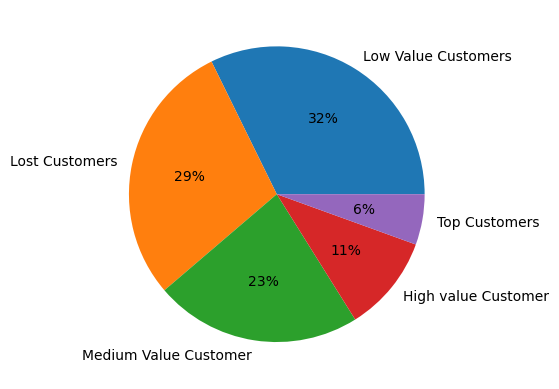

In [ ]:
plt.pie(df.Customer_segment.value_counts(),
        labels=df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
#### Unsupervise learning - k means clustering

In [ ]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 2.377197713985319, : SkewtestResult(statistic=250.25405725725847, pvalue=0.0)


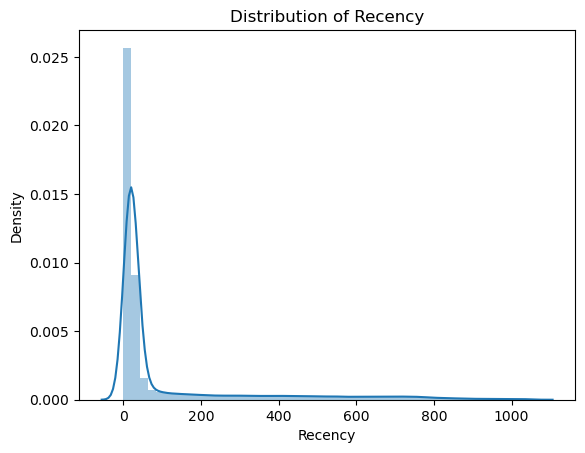

In [ ]:
d_Recency = check_skew(df,'Recency')

Frequency's: Skew: 1.8454763275340393, : SkewtestResult(statistic=217.29343073433725, pvalue=0.0)


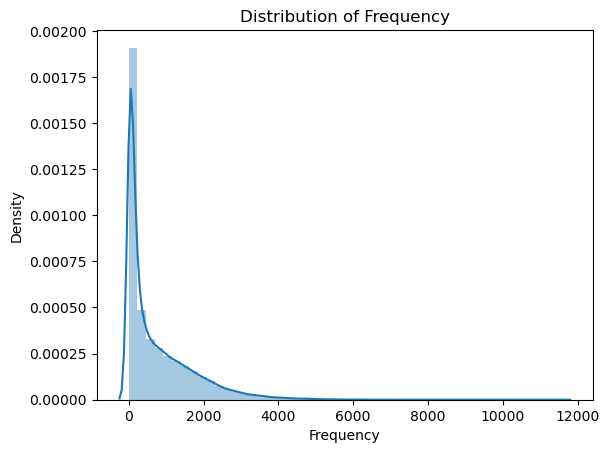

In [ ]:
d_Frequency = check_skew(df,'Frequency')

Monetary's: Skew: 5.372496029418442, : SkewtestResult(statistic=361.0957322618854, pvalue=0.0)


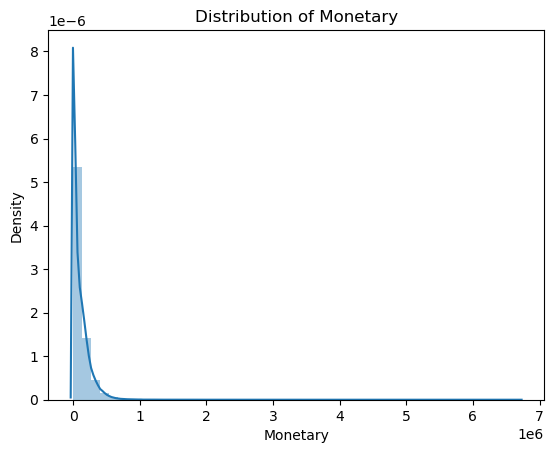

In [ ]:
m_Monetary = check_skew(df,'Monetary')

In [ ]:
df_log = df[['Recency','Frequency','Monetary']].copy()

In [ ]:
df_log['Recency'] = np.log(df['Recency'] + 1)
df_log['Frequency'] = np.log(df['Frequency'] + 1)
df_log['Monetary'] = np.log(df['Monetary'] + 1)

Recency's: Skew: 1.396115132251396, : SkewtestResult(statistic=182.55397564507348, pvalue=0.0)
Frequency's: Skew: -0.64105736942017, : SkewtestResult(statistic=-100.79684416600492, pvalue=0.0)
Monetary's: Skew: -1.315319769328168, : SkewtestResult(statistic=-175.41576746749348, pvalue=0.0)


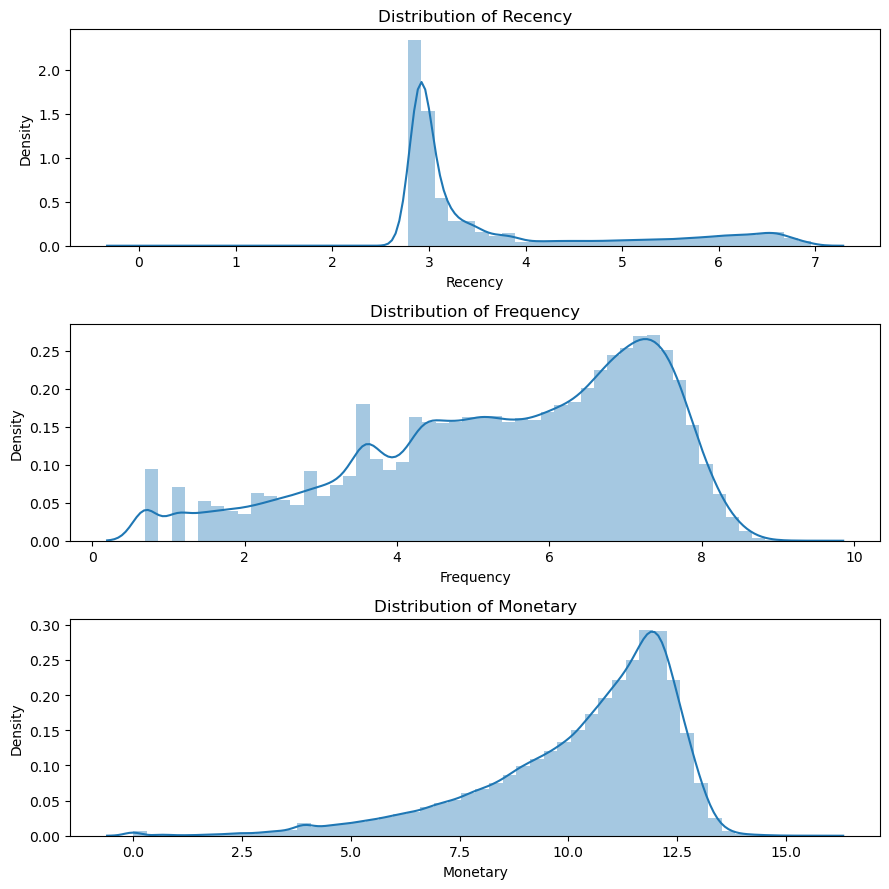

In [ ]:
#Removing Skewness

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_log,'Recency')
plt.subplot(3, 1, 2)
check_skew(df_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_log,'Monetary')
plt.tight_layout()

In [ ]:
scaler = StandardScaler()
scaler.fit(df_log)
RFM_Table_scaled = scaler.transform(df_log)

In [ ]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_log.columns)
RFM_Table_scaled.head()

,Recency,Frequency,Monetary
0,-0.659468,0.695387,0.087194
1,0.135874,-0.111951,-0.661204
2,-0.272737,-1.607830,-1.478630
3,-0.659468,1.128884,0.938944
4,-0.460702,-0.136948,0.734377


In [ ]:
###Finding the optimal Number of Clusters!

In [ ]:
###Elbow method

In [ ]:
# from scipy.spatial.distance import cdist
# distortions = [] 
# inertias = [] 
# mapping1 = {} 
# mapping2 = {} 
# K = range(1,10) 
  
# for k in K: 
#     #Building and fitting the model 
#     kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
#     kmeanModel.fit(RFM_Table_scaled)     
      
#     distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
#                       'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
#     inertias.append(kmeanModel.inertia_) 
  
#     mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
#                  'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
#     mapping2[k] = kmeanModel.inertia_

In [ ]:
# The image is obtained by flattening three-dimensional graphs (created from Recency, Frequency, and MonetaryValue) into two-dimensional graphs for ease of visualization. The technique for flattening high dimensional graph and visualizing it in a two-dimensional format is known as t-Distributed Stochastic Neighbor Embedding (t-SNE). 

In [ ]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
# Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

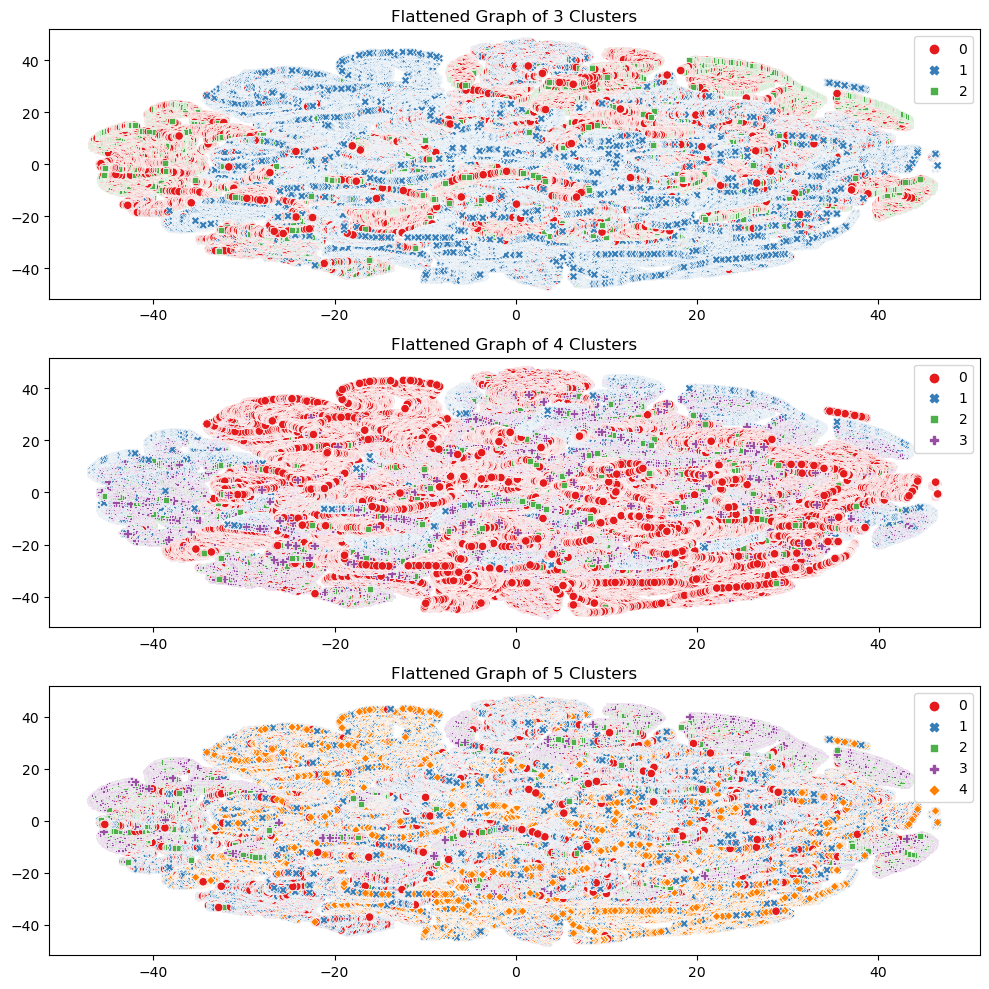

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(RFM_Table_scaled, 3, RFM_Table)

plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_Table)

plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, RFM_Table)

plt.tight_layout()

In [ ]:
#snake plot

In [ ]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=RFM_Table.index, 
                                       columns=RFM_Table.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']
# Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['index_col', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

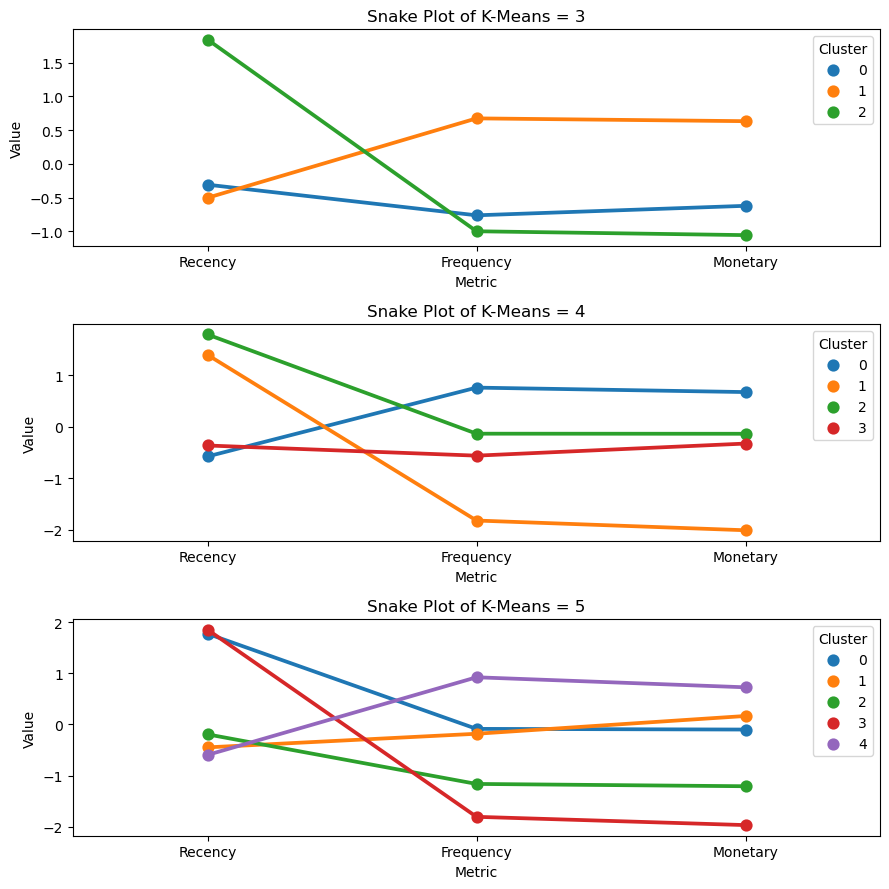

In [ ]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_Table_scaled, df_rfm_k3, RFM_Table)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, RFM_Table)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_Table_scaled, df_rfm_k5, RFM_Table)

plt.tight_layout()

In [ ]:
def rfm_values(df):

    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [ ]:
rfm_values(df_rfm_k3)

Recency Frequency  Monetary       
           mean      mean      mean  count
Cluster                                   
0          30.0      96.0   20990.0  43050
1          28.0    1234.0  167958.0  98784
2         467.0     143.0   16882.0  34040